# TO BEGIN
* Create a bunch of artificial data and explore histograms of compatibility scores

In [4]:
import pandas as pd
import numpy as np
from random import shuffle
from numpy.random import randint
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [5]:
# Calculating the target variables
def prepDF_and_calculateTarget(answers, pivot_approach=False):
    # Pulling out info on the diagnosis                                                              
    condition = answers['Diagnosis']

    # Identifying relevant medications                                                               
    ConditionFile = glob.glob('UniqueMedications/*{:s}*csv'.format(condition))[0]
    condDF = pd.read_csv(ConditionFile, sep='$', usecols=[1])
    condMeds = [med.strip() for med in list(condDF['Medication'])]

    # Reading in the massive processed dataframe                                                     
    dataframe = pd.read_csv('Final_processed_reviews/{:s}_processed.csv'.format(condition),
                            sep='$', index_col=0)

    satisfaction = dataframe['Satisfaction']

    # Identifying the feature columns and gathering that data                                        
    feature_columns = list(condMeds)+['Postive polarity','Negative polarity']
    DF = dataframe.drop(columns=[col for col in dataframe.columns if col not in feature_columns])

    # read in cluster file                                                                           
    clustering = pd.read_csv('SideEffectMatching/cluster_file.csv', sep='$', index_col=0)
    SEs1 = clustering.loc[answers['SE1']][clustering.loc[answers['SE1']].eq(1)].index
    fSE1 = [dataframe[col] for col in SEs1 if col in dataframe.columns]
    if fSE1:
        fSE1 = (np.vstack(fSE1).sum(axis=0)>0)
    else:
        fSE1 = np.array([0]*len(dataframe))
    
    SEs2 = clustering.loc[answers['SE2']][clustering.loc[answers['SE2']].eq(1)].index
    fSE2 = [dataframe[col] for col in SEs2 if col in dataframe.columns]
    if fSE2:
        fSE2 = (np.vstack(fSE2).sum(axis=0)>0)
    else:
        fSE2 = np.array([0]*len(dataframe))
        
    SEs3 = clustering.loc[answers['SE3']][clustering.loc[answers['SE3']].eq(1)].index
    fSE3 = [dataframe[col] for col in SEs3 if col in dataframe.columns]
    if fSE3:
        fSE3 = (np.vstack(fSE3).sum(axis=0)>0)
    else:
        fSE3 = np.array([0]*len(dataframe))
    
    # Calculating target variable                                                                    
    w0 = answers['eff_rating']

#     EffStars = (dataframe['Effectiveness']-1)/4.
    
    # Weighting things more heavily that are closer to the median
    EffStars = (1-np.abs(dataframe['Effectiveness']-dataframe['Effectiveness'].median())/4)

#     fSE1 = fSE1/3
#     fSE2 = fSE2/3
#     fSE3 = fSE3/3
    
    wse1 = answers['SE1_rate']
    wse2 = answers['SE2_rate']
    wse3 = answers['SE3_rate']

# This score was designed to measure how "compatible" a drug would be with a user based on a review
#     w1 = 1# - w0
#     CS = w0*EffStars - w1*( wse1*fSE1  +  wse2*fSE2  +  wse3*fSE3 ) / (wse1+wse2+wse3)
#     CS += 1 # Make range from 0 to 1

# This compatibility scores the info density of a review for the user
    w1 = 1 - w0
    CS = (w0*EffStars + w1*( wse1*fSE1  +  wse2*fSE2  +  wse3*fSE3 )/(wse1+wse2+wse3)) / (w0+w1)
    
    # Returning dataframe to fit and compatibility score    
    if pivot_approach:
        return CS, dataframe['Full Review']
    else:
        return DF, CS, satisfaction, dataframe['Full Review']


In [6]:
def create_random_answer(no_effectiveness=True,
                         condition='Bipolar-Disorder', 
                         cluster_file='SideEffectMatching/cluster_file.csv'):
    
    clusterDF = pd.read_csv(cluster_file, sep='$', index_col=0)
    clusters = list(clusterDF.index)
    
    response = {}
    response['Diagnosis'] = condition
    
    # Randomly draw three side effect clusters
    shuffle(clusters)
    concerns = [cluster for cluster in clusters[:3]]
    response['SE1'] = concerns[0]
    response['SE2'] = concerns[1]
    response['SE3'] = concerns[2]
    
    # Randomly set three weights for tolerance and one for effectiveness
    tolerances = (randint(1,11,size=4)-1)/10. + 0.1
    response['SE1_rate'] = tolerances[0]
    response['SE2_rate'] = tolerances[1]
    response['SE3_rate'] = tolerances[2]
    
    # Consider effectiveness
    if not no_effectiveness:
        response['eff_rating'] = tolerances[3]
    else:
        response['eff_rating'] = 0
        
    return response

In [7]:
def generate_report(condition, no_effectiveness=True, answers=False):
    if not answers:
        answers = create_random_answer(condition=condition, no_effectiveness=no_effectiveness)
        
    feature_frame, comp_score, sats, review = prepDF_and_calculateTarget(answers)
    feature_frame.reset_index() # Just in case
    
    review = np.array(review)
    comp_score = np.array(comp_score)
    
    medications = [col for col in feature_frame.columns if col not in ['Positive polarity', 'Negative polarity']]
    
    for key in ['SE1','SE2','SE3']:
        print("I am concerned about {:s}, and I weight that concern as {:g}/10".format(answers[key],
                                                                                   answers[key+'_rate']*10))
    
    if not no_effectiveness:
        print("If the medication was effective, these side effects would be tolerable --> {:g}/10".format(10*answers['eff_rating']))
    
    fig, ax = plt.subplots(1,figsize=(10,6), constrained_layout=True)
    frac = 0.1
    
    bin_edges = np.arange(0,1+frac*0.1,frac) # To account that a med can have a score of 0
    
    
    colors = lambda x, total: cm.gist_rainbow((x+0.5)/total)
    
    width = frac/len(medications)
    review_for_each_med = []
    for i,med in enumerate(medications):
        locs = np.array(feature_frame[feature_frame[med].eq(1)].index)
        review_for_each_med.append((med, review[locs][comp_score[locs].argmax()]))

        test = comp_score[locs]
        print(med, test.min().round(3), test.max().round(3))
        
        counts, empty = np.histogram(comp_score[locs], range=(0,1))
        
        bar_locs = np.arange(len(bin_edges)-1)*frac + i*width
       
        ax.bar(bar_locs, counts/len(locs)*100, width=width, label=med,alpha=0.5,
               color=colors(i,len(medications)), align='edge')

    for i in range(int(1/frac)): plt.axvline((i+1)*frac, color='k', linestyle=':')
        
    plt.xlim(0,1)
    plt.ylim(0,110)
    plt.legend(loc='best', ncol=len(medications)//2)
    ax.set_xlabel('Compatibility Score')
    ax.set_ylabel('% of reviews')
    
    return review_for_each_med, comp_score

I am concerned about Memory and concentration issues, and I weight that concern as 2/10
I am concerned about Stomach issues, and I weight that concern as 9/10
I am concerned about Menstrual changes, and I weight that concern as 8/10
If the medication was effective, these side effects would be tolerable --> 6/10
Eskalith 0.15 0.832
Depakene 0.15 0.789
Tegretol 0.15 0.832
Lamictal 0.15 0.958
Seroquel 0.15 1.0
Zyprexa 0.15 0.958
Sarafem 0.15 0.789
Depakote 0.15 0.832


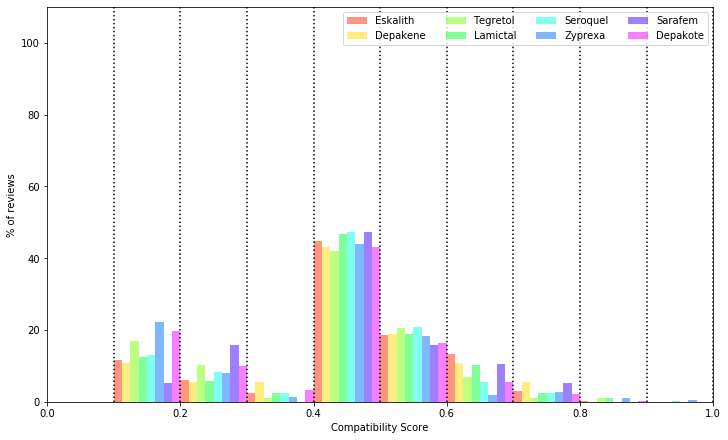

In [8]:
# RICOI = score for how relevant review is to user
x, RICOI = generate_report('Bipolar-Disorder', no_effectiveness=False)

In [9]:
for item in x:
    print(item[0])
    print(item[1],'\n\n')

Eskalith
I feel it is wrong to tell anothernot to take this med. I have been on 450mg per day for over 1 year, I also take generic xanax and Ambien CR. I attempted suicide twice in 2010, that was when I was diagnosed with Bipolar and depression. I was first on Depakote, it worked ok, then changed to Seroquil (was the best but to expensive) then put on Lithium. I have had no problems with it, that does not mean I won't in the future as we all know you become used to the med and it can become ineffective. but like all meds it depends on the person as to how and if it works. so do what your Doctor says and if you experience any side effects get to the Doctor. 


Depakene
At first i couldn't tell it was working. About a month later i started feeling a change 


Tegretol
I take 100 mg a day to stabilize mood. It's worked well, doesn't prevent down feelings but seems to help limit them. After 3 years, am starting to notice short-term memory loss.  Whenever I tried 150 mg, I felt slightly slu

# Creating a feature matrix to learn to classify the reviews with

In [ ]:
import spacy
from spacy.tokenizer import Tokenizer
import en_core_web_lg
nlp = en_core_web_lg.load()
tokenizer = Tokenizer(nlp.vocab)

from autocorrect import Speller
spell = Speller(lang='en')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.sentiment import vader
VADER_SIA = vader.SentimentIntensityAnalyzer()

In [ ]:
def find_polarity_scores(reviews):
    VADERscorePos = []
    VADERscoreNeg = []
    for rev in reviews:
        VADERscorePos.append(VADER_SIA.polarity_scores(rev)['pos'])    
        VADERscoreNeg.append(VADER_SIA.polarity_scores(rev)['neg'])            
        
    return VADERscorePos, VADERscoreNeg

# Magic tokenizer thing
def spacyTokenizer(s: str)-> list:
    doc = tokenizer(s.lower().strip())
    tokens = []
    for token in doc:
        if not token.is_stop and token.is_alpha and token.lemma_ != '-PRON-':
            tokens.append(token.lemma_)
        
    return tokens

# Not super useful to take the mean across columns, instead look at top 10 scoring words in each side effect
def findTfidf(strList):
    tfidf_vectr = TfidfVectorizer()
    corpus = [' '.join(SE) for SE in strList]
    tfidf_score = tfidf_vectr.fit_transform(corpus).toarray()
    features = np.array(tfidf_vectr.get_feature_names())
    indices = tfidf_score.sum(axis=1).argsort()[::-1]
    
    tfidf_score = tfidf_score[indices[:100]]
    features = features[:100]
    
    return tfidf_score, features

def parseRev4Class(reviews, return_df=False):
    clean_reviews = [spacyTokenizer(rev.replace('/', ' ')) for rev in reviews]
    tfidf_score, features = findTfidf(clean_reviews)
    
    pos, neg = find_polarity_scores(reviews)
    
    dataframe_info = []
    for i in range(len(pos)):
        info_row = {}
        info_row['Full Review'] = reviews[i]
        info_row['Positive polarity'] = pos
        info_row['Negative polarity'] = neg
        for score, f in zip(tfidf_score, features): info_row[f] = score
        dataframe_info.append(info_row)
        
    return pd.DataFrame(dataframe_info)

def matchReviews(feature_frame, RICOI_reviews):
    for i in len(RICOI_reviews):
        print(feature_frame['Full Review'][i][:50], '\n', RICOI_reviews[:50], '\n\n')
    
    #return np.array([feature_frame[feature_frame['Full Review'].eq(rev)].index[0] for rev in RICOI_reviews])

def generate_testcase(condition, no_effectiveness=True, answers=False):
    if not answers:
        answers = create_random_answer(condition=condition, no_effectiveness=no_effectiveness)
        
    comp_score, reviews = prepDF_and_calculateTarget(answers, pivot_approach=True)
    
    feature_frame = parseRev4Class(reviews)
    
    return feature_frame, comp_score

# Yay tree methods
* These should do a good job of handling the imbalance in our target variable (generally, side effect mentions will be imbalanced)
* Trees can handle a mix of categorical and continuous data
* XGBoost will be fast
* Can try Catboost? and something else I don't remember?

In [ ]:
from xgboost import XGBRegressor#Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import scikitplot as skplt
from scikitplot.metrics import plot_cumulative_gain

In [ ]:
def xgboost_it(x, y, split=0.8, seed=616, xgseed=4):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1-split), 
                                                        random_state=seed)
    
    # Fit the model
    model = XGBRegressor(objective='rank:ndcg',
                          seed=xgseed)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # Getting a metric of model reliability
    #R2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Getting ranked feature importance
    imp = model.feature_importances_
    ranked_feats = x.columns[imp.argsort()[::-1]]
    
    print(imp[imp.argsort()][::-1])
    
    return MSE, ranked_feats, x_test, y_test, y_pred

In [ ]:
def fit_model(condition):
    
    feature_frame, target_variable = generate_testcase(condition)
    feature_frame = feature_frame.drop(columns='Full Review')
    
    import pdb
    pdb.set_trace()
    
    # Can we just grab satisfactions from those who have experienced side effects?
    # Is that even a good idea?
    
    R2, ranking,x_test,  y_test, y_pred = xgboost_it(feature_frame, target_variable)
    
    # Report on everything
    print('\n\nI achieved an MSE of {:g}\n\n'.format(R2))
    for i in range(3):
        print('I rank {:s} as the number {:g} thing you should look at'.format(ranking[i], i+1))
          
            
    return x_test, y_test, y_pred

In [ ]:
xt, yt, yp = fit_model('Depression')

In [ ]:
plt.scatter(np.arange(yt.size),yt, color='orange')
plt.scatter(np.arange(yt.size), yp, color='skyblue')

In [ ]:
np.unique(yp)
